In [1]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from imvc.datasets import LoadDataset
from imvc.impute import MOFAImputer
from imvc.preprocessing import MultiViewTransformer
from imvc.ampute import Amputer

In [3]:
Xs = LoadDataset.load_dataset(dataset_name="buaa")
p = 0.3
amputed_Xs = Amputer(p= p, mechanism="MCAR", random_state=42).fit_transform(Xs)
for X in amputed_Xs:
    X.iloc[np.random.default_rng(42).choice([True, False], p= [1-p,p], size = X.shape)] = np.nan

In [4]:
n_components_list = [1, 2, 4, 8, 16]
errs = []
for n_components in n_components_list:
    pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                             MOFAImputer(n_components = n_components, random_state=42).set_output(transform="pandas"))
    transformed_Xs = pipeline.fit_transform(amputed_Xs)
    
    
    err = np.mean([mean_squared_error(X, transformed_X) for X,transformed_X in zip(Xs, transformed_Xs)])
    errs.append(err)

In [5]:
pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                         MultiViewTransformer(SimpleImputer().set_output(transform= "pandas")))
transformed_Xs = pipeline.fit_transform(amputed_Xs)
baseline = np.mean([mean_squared_error(X, transformed_X) for X,transformed_X in zip(Xs, transformed_Xs)])

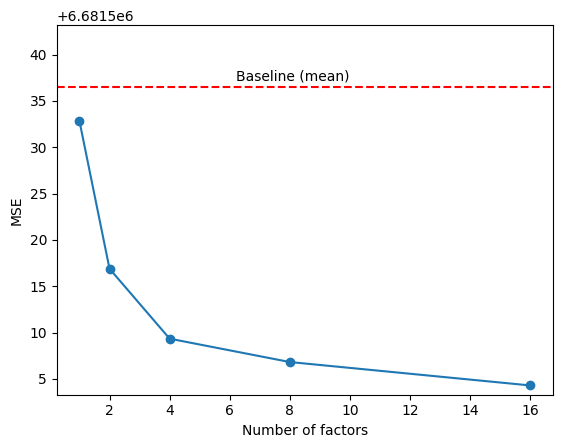

In [6]:
ax = pd.Series(errs, index= n_components_list).plot(style= "-o", ylim= (min(errs) -1, baseline*1.000001), ylabel= "MSE", xlabel= "Number of factors", rot= 0)
ax.text(np.mean(n_components_list), baseline*1.0000001, "Baseline (mean)")
_ = ax.axhline(baseline, linestyle= "--", color= "red")